In [1]:
import pandas as pd
import numpy as np
from utils import *
import pytensor.tensor as pt  # Import PyTensor (Theano backend)

In [2]:
df = read_dd_data('../data/PD_data')


In [3]:
df

,rcert,runcert,event_prob,choice,condition,rt,odds,participant
0,5.0,9.50,0.10,0.0,1.0,2013.5,9.000000,bh348lli7
1,10.0,11.11,0.90,0.0,1.0,514.4,0.111111,bh348lli7
2,1.0,1.10,0.50,0.0,1.0,424.2,1.000000,bh348lli7
3,1.0,31.00,0.25,0.0,1.0,398.2,3.000000,bh348lli7
4,20.0,80.00,0.50,0.0,1.0,538.3,1.000000,bh348lli7
...,...,...,...,...,...,...,...,...
9795,-10.0,-100.00,0.10,0.0,2.0,1504.1,9.000000,u3yyfob1i
9796,-10.0,-40.00,0.25,1.0,2.0,1856.4,3.000000,u3yyfob1i
9797,-5.0,-9.50,0.10,1.0,2.0,1911.6,9.000000,u3yyfob1i
9798,-50.0,-100.00,0.75,0.0,2.0,2848.4,0.333333,u3yyfob1i


In [4]:
df.dtypes

rcert          float64
runcert        float64
event_prob     float64
choice         float64
condition      float64
rt             float64
odds           float64
participant     object
dtype: object

In [5]:
print(df.isna().sum())  # Check for NaNs
print(df.describe())  # Look for extreme values

rcert          0
runcert        0
event_prob     0
choice         0
condition      0
rt             0
odds           0
participant    0
dtype: int64
             rcert      runcert   event_prob       choice    condition  \
count  9749.000000  9749.000000  9749.000000  9749.000000  9749.000000   
mean      0.068212     0.385589     0.500164     0.393887     1.498513   
std      24.579049   562.935370     0.298548     0.488635     0.500023   
min     -50.000000 -4550.000000     0.100000     0.000000     1.000000   
25%     -10.000000   -28.000000     0.250000     0.000000     1.000000   
50%       1.000000     1.010000     0.500000     0.000000     1.000000   
75%      10.000000    31.000000     0.750000     1.000000     2.000000   
max      50.000000  4550.000000     0.900000     1.000000     2.000000   

                rt         odds  
count  9749.000000  9749.000000  
mean   2513.978336     2.690339  
std    1438.240239     3.318231  
min     200.000000     0.111111  
25%    1545.40

In [6]:
# Extract participant information
participants = df["participant"].unique()
n_participants = len(participants)

# Convert participant IDs to integer indices
participant_idx = {pid: i for i, pid in enumerate(participants)}
df["participant_idx"] = df["participant"].map(participant_idx)

# standarize rewards and reaction times
df["rcert"] = (df["rcert"] - df["rcert"].mean()) / df["rcert"].std()
df["runcert"] = (df["runcert"] - df["runcert"].mean()) / df["runcert"].std()
df["rt"] = (df["rt"] - df["rt"].mean()) / df["rt"].std()

df

,rcert,runcert,event_prob,choice,condition,rt,odds,participant,participant_idx
0,0.200650,0.016191,0.10,0.0,1.0,-0.347980,9.000000,bh348lli7,0
1,0.404075,0.019051,0.90,0.0,1.0,-1.390295,0.111111,bh348lli7,0
2,0.037910,0.001269,0.50,0.0,1.0,-1.453011,1.000000,bh348lli7,0
3,0.037910,0.054384,0.25,0.0,1.0,-1.471088,3.000000,bh348lli7,0
4,0.810926,0.141427,0.50,0.0,1.0,-1.373678,1.000000,bh348lli7,0
...,...,...,...,...,...,...,...,...,...
9795,-0.409626,-0.178325,0.10,0.0,2.0,-0.702162,9.000000,u3yyfob1i,48
9796,-0.409626,-0.071741,0.25,1.0,2.0,-0.457210,3.000000,u3yyfob1i,48
9797,-0.206201,-0.017561,0.10,1.0,2.0,-0.418830,9.000000,u3yyfob1i,48
9798,-2.037028,-0.178325,0.75,0.0,2.0,0.232521,0.333333,u3yyfob1i,48


In [ ]:
# TODO: error after standarizing rewards and reaction times and chancing hyperpriors (mu and sigma)

In [7]:
# Extract observed data
rcert = df["rcert"].values
runcert = df["runcert"].values
event_prob = df["event_prob"].values
choice_data = df["choice"].astype(int).values  # Ensure it's an integer for Bernoulli
rt_data = df["rt"].values
participant_ids = df["participant_idx"].values  # Integer IDs

# Define hierarchical PyMC model
with pm.Model() as model:
    # Group-level priors
    mu_k = pm.Normal("mu_k", mu=0, sigma=1)  
    sigma_k = pm.HalfNormal("sigma_k", sigma=1)  
    
    mu_beta = pm.Normal("mu_beta", mu=0, sigma=1)
    sigma_beta = pm.HalfNormal("sigma_beta", sigma=1)

    mu_beta0 = pm.Normal("mu_beta0", mu=0, sigma=1)
    sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=1)

    mu_beta1 = pm.Normal("mu_beta1", mu=0, sigma=1)
    sigma_beta1 = pm.HalfNormal("sigma_beta1", sigma=1)

    # Participant-level parameters (hierarchical structure)
    k = pm.Normal("k", mu=mu_k, sigma=sigma_k, shape=n_participants)
    beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=n_participants)
    beta0 = pm.Normal("beta0", mu=mu_beta0, sigma=sigma_beta0, shape=n_participants)
    beta1 = pm.Normal("beta1", mu=mu_beta1, sigma=sigma_beta1, shape=n_participants)

    # Compute subjective values using hyperbolic discounting
    SV_certain = rcert
    SV_uncertain = runcert / (1 + k[participant_ids] * event_prob)

    # Choice model (Bernoulli with logistic function)
    prob_choose_uncertain = pm.Deterministic("prob_choose_uncertain",
        pm.math.sigmoid(beta[participant_ids] * (SV_uncertain - SV_certain)) # TODO: check order of SV_uncertain and SV_certain
    )
    choice = pm.Bernoulli("choice", p=prob_choose_uncertain, observed=choice_data)

    # Reaction time model (log-normal)
    decision_difficulty = (SV_uncertain - SV_certain) ** 2
    mu_RT = beta0[participant_ids] + beta1[participant_ids] * decision_difficulty
    RT = pm.Lognormal("RT", mu=mu_RT, sigma=0.3, observed=rt_data)

    # Run sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu_k': array(0.41775195), 'sigma_k_log__': array(0.5948918), 'mu_beta': array(0.33872553), 'sigma_beta_log__': array(0.52102459), 'mu_beta0': array(-0.71384236), 'sigma_beta0_log__': array(0.0964961), 'mu_beta1': array(-0.04173737), 'sigma_beta1_log__': array(0.54939906), 'k': array([ 0.25406177, -0.47082834,  0.8059364 ,  0.20730089,  1.24058197,
       -0.45511628,  0.94825788,  0.19372637,  0.27857301,  0.43182446,
        0.11173779,  0.54021996,  0.31889901,  1.12001943,  1.40279036,
        1.357132  ,  1.34248273,  1.40582049,  0.51368779, -0.44216963,
       -0.45714321,  1.40819677,  0.93241142,  1.06294017,  0.60934327,
        1.35322667, -0.15167971,  1.24672041,  0.33949162, -0.50898706,
       -0.33067012, -0.22049759, -0.14319169,  0.86299758, -0.38185194,
        0.48903552,  0.60312118,  1.23371156, -0.26867525, -0.03386379,
        0.1424188 ,  0.88773387, -0.43778546,  1.16770197,  0.87878715,
       -0.53831169,  0.42427017, -0.27308648, -0.39461857]), 'beta': array([ 0.64199384,  0.36037264,  0.94867139,  0.81140681,  0.75072981,
        1.24260827, -0.51887883,  0.52406842,  0.81216268, -0.58787939,
       -0.41944551,  1.03226711,  0.52120128,  0.40513218,  0.07457346,
       -0.30051834, -0.17368795,  0.88391375,  1.10445683,  0.91506286,
       -0.17722532, -0.48377281,  0.34526377,  0.9418472 ,  1.1753249 ,
       -0.52599356, -0.38830967,  0.95972071,  0.46016938,  0.17471473,
        0.62465905, -0.24436858,  0.41591182,  0.1312726 ,  0.06122333,
        0.99621412,  0.39417394,  0.84262191,  0.80593878, -0.32957183,
       -0.49541652,  0.33581229, -0.08376003,  0.97409806, -0.54175273,
        0.33483076,  1.28032499,  0.92362465,  0.14447827]), 'beta0': array([-1.35846485, -0.74204061, -0.70948967,  0.09077283, -0.35465643,
       -0.86233079, -1.59638094, -1.12762266, -1.42462537, -1.18316853,
       -1.18147182, -0.15101512, -0.81291649, -1.46761428, -0.41184752,
       -1.35380853, -1.3408102 , -1.62199523, -1.37632304, -1.19615102,
       -1.15124395, -0.62866078,  0.25147936, -0.66542552, -1.12896561,
       -0.36010165, -1.37620659, -0.77404334, -1.4900533 , -0.0933874 ,
       -1.1023872 , -0.73413316, -0.12958636, -1.49274442, -0.04147033,
       -0.18930538, -0.26161605, -1.54072238,  0.11265358, -1.71283052,
       -0.14579959, -1.54586378, -1.18487456,  0.21100943, -0.80464491,
       -0.70832678, -1.59659282, -1.55873405, -0.70342053]), 'beta1': array([-0.74843158, -0.84363314, -0.26989319, -1.03456175,  0.17273225,
        0.02297864,  0.10815991, -0.1377853 ,  0.53229317, -0.15921772,
       -0.50345702, -0.26635915, -1.02015657, -1.02372823, -0.10732223,
        0.15695262, -0.88824726,  0.82497341, -0.13575311,  0.61440407,
       -0.30627939,  0.69236759, -0.26011194,  0.79138705,  0.38657842,
        0.50760746,  0.50192063,  0.36336423,  0.06382683, -0.63481428,
        0.52153196,  0.15934108, -0.2840749 , -0.99828666,  0.77197799,
        0.72668958,  0.38862965,  0.11177754, -0.2486964 ,  0.67674632,
       -0.11102616, -0.72145405, -0.46621666, -0.98004983, -0.36021043,
        0.22642684,  0.21844922, -1.01757114,  0.77216261])}

Logp initial evaluation results:
{'mu_k': -1.01, 'sigma_k': -1.27, 'mu_beta': -0.98, 'sigma_beta': -1.12, 'mu_beta0': -1.17, 'sigma_beta0': -0.74, 'mu_beta1': -0.92, 'sigma_beta1': -1.18, 'k': -77.28, 'beta': -73.29, 'beta0': -56.86, 'beta1': -74.64, 'choice': -7105.16, 'RT': -inf}
You can call `model.debug()` for more details.

/opt/miniconda3/envs/humml/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/miniconda3/envs/humml/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/miniconda3/envs/humml/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/miniconda3/envs/humml/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


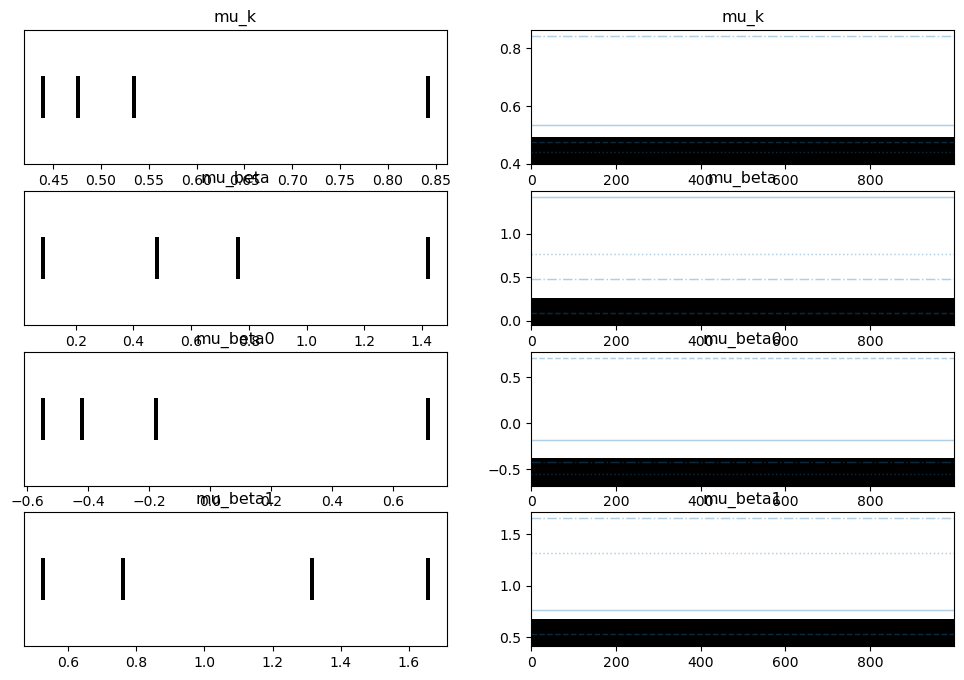

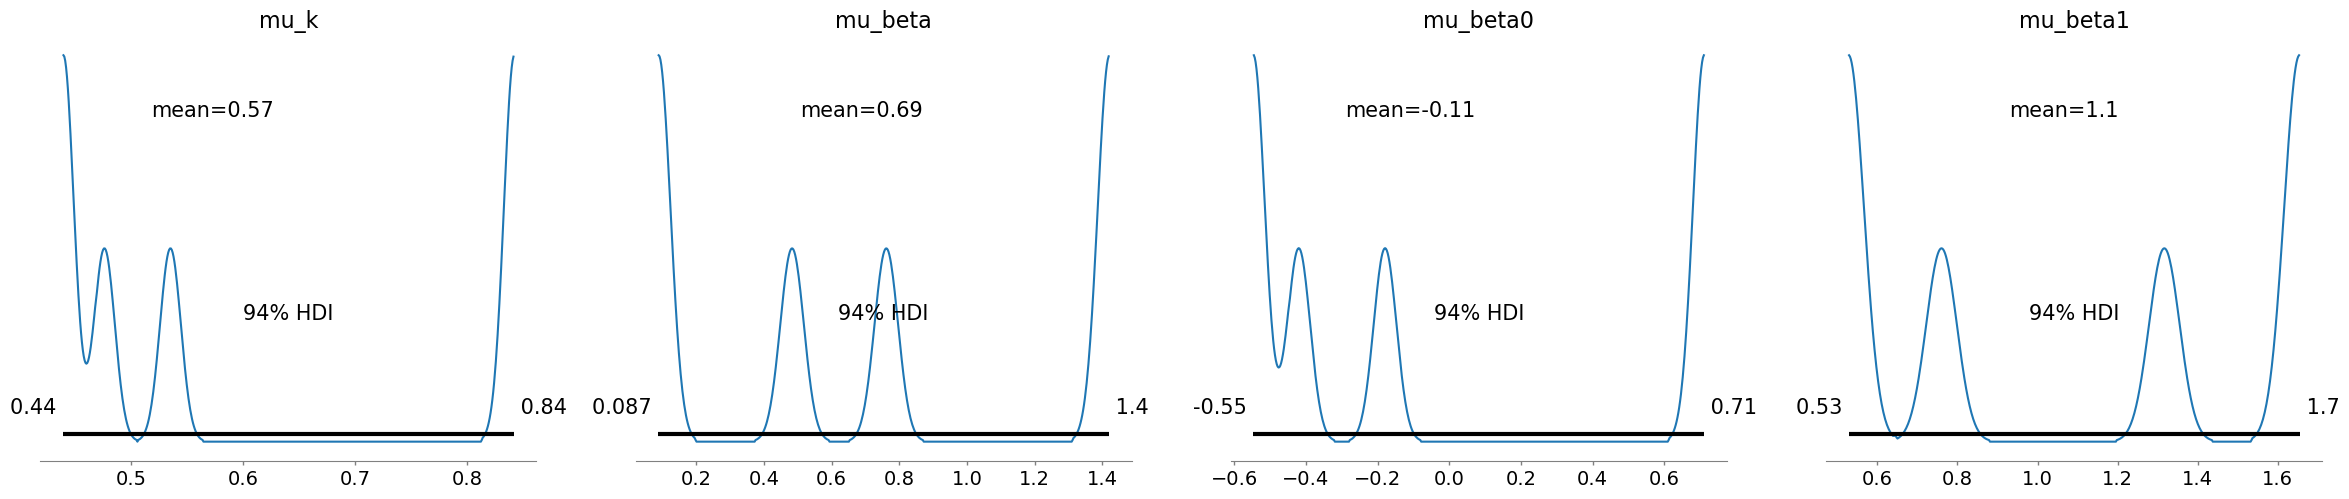

/opt/miniconda3/envs/humml/lib/python3.10/site-packages/arviz/stats/diagnostics.py:591: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
/opt/miniconda3/envs/humml/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


R-hat values (should be ~1.00):
 <xarray.Dataset> Size: 159kB
Dimensions:                      (k_dim_0: 49, beta_dim_0: 49, beta0_dim_0: 49,
                                  beta1_dim_0: 49,
                                  prob_choose_uncertain_dim_0: 9749)
Coordinates:
  * k_dim_0                      (k_dim_0) int64 392B 0 1 2 3 4 ... 45 46 47 48
  * beta_dim_0                   (beta_dim_0) int64 392B 0 1 2 3 ... 45 46 47 48
  * beta0_dim_0                  (beta0_dim_0) int64 392B 0 1 2 3 ... 46 47 48
  * beta1_dim_0                  (beta1_dim_0) int64 392B 0 1 2 3 ... 46 47 48
  * prob_choose_uncertain_dim_0  (prob_choose_uncertain_dim_0) int64 78kB 0 ....
Data variables: (12/13)
    mu_k                         float64 8B 3.163e+07
    mu_beta                      float64 8B 3.163e+07
    mu_beta0                     float64 8B 3.163e+07
    mu_beta1                     float64 8B 3.163e+07
    k                            (k_dim_0) float64 392B 3.163e+07 ... 3.163e+07
    b

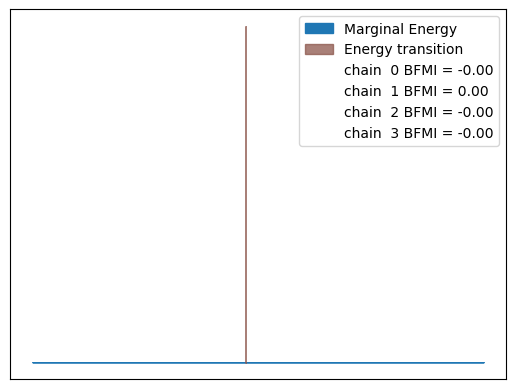

In [7]:
import arviz as az
import matplotlib.pyplot as plt

# Trace plot: Check parameter convergence across chains
az.plot_trace(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"])
plt.show()

# Posterior distributions: Check inferred parameter values
az.plot_posterior(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"])
plt.show()

# Check R-hat values: Should be close to 1.00 for good convergence
rhat_values = az.rhat(trace)
print("R-hat values (should be ~1.00):\n", rhat_values)

# Check effective sample size (ESS): Should be > 200 per chain
ess_values = az.ess(trace)
print("Effective Sample Size (ESS) per parameter:\n", ess_values)

# Energy plot: Helps diagnose divergences
az.plot_energy(trace)
plt.show()